
## Machine Learning Part 2 Table of contents
* [Setup]
* [Missing Values Strategy](#missing)
    * [Drop Columns](#drop)
    * [Fill Columns w/ Impute](#impute)
    * [Fill Columns w/ Impute and Create a missing column](#impute+)
* [Dealing with Categorical Variables; Label & One-Hot Encoding](#categorical)
* [Screening Method: Basic](#screen)
* [Pipelines](#pipeline)
* [Cross-Validation](#cross)
* [XGBoost Model/Intro](#xgboost)
    * [Parameter Tuning](#tuning)
    * [Model Selection](#model)
    * [Plotting](#plot)
        * [SHAP Plotting](#Shap)
        * [Partial Feature Dependence Graphs](#dependence)
        * [Feature Dependence Matrix](#matrix)
* [Data Leakage](#leakage)

There are some code that is not working; because the datasets and or specifications become variable!

#### Setup

First load libraries and set up a simple dataset to test some functionality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import Imputer


#used to remove top axis permanently
#plt.rcParams["axes.spines.top"] = False
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Standard Machine Learning Setup

Here is an example of a standard setup for a model at bare basics; notice there is a lot steps preparing data. The model is so bad that the numbers fluctuate every time it runs.

In [6]:
# Load data
melb_data = pd.read_csv("Data\melb_data.csv") 
#select the X and y

#Remove missing values from the target and missing columns
melb_data.dropna(axis=0, subset=['Price'], inplace=True)
melb_data.dropna(axis='columns', inplace=True)

#Get X and y values
melb_target = melb_data.Price
melb_predictors = melb_data.drop(['Price'], axis=1)

# For the sake of keeping the example simple, we'll use only numeric predictors. 
melb_numeric_predictors = melb_predictors.select_dtypes(exclude=['object'])

#Remove missing values; otherwise algorithm cannot run

# Setup training and testing data
X_train, X_test, y_train, y_test = train_test_split(melb_numeric_predictors, 
                                                    melb_target,
                                                    train_size=0.7, 
                                                    test_size=0.3, 
                                                    random_state=0)

# fit model no training data
model = RandomForestRegressor()
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(mean_absolute_error(y_test, predictions))

##############################################################################3

#Define function to get values of the model
def score_dataset(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds)


Accuracy: 0.12%
190689.61585665194


In [53]:
X_train.head(2)

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Propertycount
4431,1,5.5,3070.0,1.0,1.0,0.0,-37.7783,144.9954,11364.0
775,4,13.0,3204.0,4.0,1.0,580.0,-37.9263,145.0422,6795.0


## Handling Missing Values <a name="missing"></a>

The process is very important because models **do not work** if data is missing

**Methods:**

1) Dropping whole columns and the predictor values with missing data
    * Not recommended because valuable information may be lost
2) Imputation: Plug in the missing values with the average value of the column.
    * Statisticians might use more complicated methods; but machine learning algorithms typically handle this fine and there is typically no difference
3) Imputation plus creating a column for missing values **Most desired**
    * It's possible that the missing data in certain columns can give information on the data; so separate between the two
    

### Method 1: Dropping Columns <a name="drop"></a>

In [7]:
    # Find the index of columns with NO missing values at any entry
cols_with_missing = [col for col in X_train.columns 
                                 if X_train[col].isnull().any()]
    # Update data with appropiate index
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_test  = X_test.drop(cols_with_missing, axis=1)
    #Print Information
print("Mean Absolute Error from dropping columns with Missing Values:")
print(score_dataset(reduced_X_train, reduced_X_test, y_train, y_test))
    # Show column values
reduced_X_train.head(2) 

Mean Absolute Error from dropping columns with Missing Values:
191958.41874878248


,Rooms,Distance,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Propertycount
4431,1,5.5,3070.0,1.0,1.0,0.0,-37.7783,144.9954,11364.0
775,4,13.0,3204.0,4.0,1.0,580.0,-37.9263,145.0422,6795.0


### Method 2: Imputation <a name="impute"></a>

In [8]:
from sklearn.impute import SimpleImputer

    #Create a 'class' of the Simple Imputer object
my_imputer = SimpleImputer()
    #transform the data using it
imputed_X_train = my_imputer.fit_transform(X_train)
imputed_X_test = my_imputer.transform(X_test)
    #Print Information
print("Mean Absolute Error from Imputation:")
print(score_dataset(imputed_X_train, imputed_X_test, y_train, y_test))
    #Print values; note this turns to an array!; The code below gets the dimension (12) whish is same as original data
imputed_X_train.shape

Mean Absolute Error from Imputation:
191717.82893669495


(9506, 9)

### Method 3: Imputation w/ Missing columns <a name="impute+"></a>

In [9]:
#Create copy of missing data
imputed_X_train_plus = X_train.copy()
imputed_X_test_plus = X_test.copy()

    #Find index of missing columns
cols_with_missing = (col for col in X_train.columns 
                                 if X_train[col].isnull().any())

    #For the respective index, add a New Column with the missing designation
for col in cols_with_missing:
    imputed_X_train_plus[col + '_was_missing'] = imputed_X_train_plus[col].isnull()
    imputed_X_test_plus[col + '_was_missing'] = imputed_X_test_plus[col].isnull()

    # Three columns had missing data; Notice the tables are False and True
print(imputed_X_train_plus.head(2))
    
    #Imputation
my_imputer = SimpleImputer()
imputed_X_train_plus = my_imputer.fit_transform(imputed_X_train_plus)
imputed_X_test_plus = my_imputer.transform(imputed_X_test_plus)
    #Print
print("Mean Absolute Error from Imputation while Track What Was Imputed:")
print(score_dataset(imputed_X_train_plus, imputed_X_test_plus, y_train, y_test))
    # Print dimension (15)
imputed_X_train_plus.shape

      Rooms  Distance  Postcode  Bedroom2  Bathroom  Landsize  Lattitude  \
4431      1       5.5    3070.0       1.0       1.0       0.0   -37.7783   
775       4      13.0    3204.0       4.0       1.0     580.0   -37.9263   

      Longtitude  Propertycount  
4431    144.9954        11364.0  
775     145.0422         6795.0  
Mean Absolute Error from Imputation while Track What Was Imputed:
191727.46141735045


(9506, 9)

## Dealing with Categorical Variables<a name="categorical"></a>

Some categorical variables can be converted to numerical rank via label encoding

![title](Images\labelenc.png)


### One-Hot Encoding <a name="onehot"></a>

* Machine Learning algorithms do not handle categorical variables/ text ; 
* So we need to **convert categorical values into dummy variables**. 
* One hot encoding creates new (binary) columns, indicating the presence of each possible value from the original data.
    * It is not recommended if categories are greater than 15; **Cardinality** is used to determine the number of unique values in a column

![title](Images\Onehotencoding.png)

### Setup

I'll be displaying the dimension at each change


In [10]:
    # Read the data
import pandas as pd
train_data = pd.read_csv('Data\mach_house\_train.csv')
test_data = pd.read_csv('Data\mach_house\_test.csv')

    # Drop houses where the target is missing; Prices missing
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)
target = train_data.SalePrice

    #  Remove missing data (Simplest way used)
cols_with_missing = [col for col in train_data.columns 
                                 if train_data[col].isnull().any()]                                  
candidate_train_predictors = train_data.drop(['Id', 'SalePrice'] + cols_with_missing, axis=1)
candidate_test_predictors = test_data.drop(['Id'] + cols_with_missing, axis=1)

print('After removing columns the dimensions are:' + str(candidate_train_predictors.shape))

    # Find index low cardinality of text columns; which is defined by object
low_cardinality_cols = [cname for cname in candidate_train_predictors.columns if 
                                candidate_train_predictors[cname].nunique() < 10 and
                                candidate_train_predictors[cname].dtype == "object"]
    # Find index of numerical columns
numeric_cols = [cname for cname in candidate_train_predictors.columns if 
                                candidate_train_predictors[cname].dtype in ['int64', 'float64']]
my_cols = low_cardinality_cols + numeric_cols

    # Add up qualified indices
train_predictors = candidate_train_predictors[my_cols]
test_predictors = candidate_test_predictors[my_cols]

print('After indexing on cardinality and suitable numerical variables the dimensions are:' + str(train_predictors.shape))

    # One hot encoding
one_hot_encoded_training_predictors = pd.get_dummies(train_predictors)

print('After one hot encoding the dimensions are:' + str(one_hot_encoded_training_predictors.shape))

    #predictor without categoricals
predictors_without_categoricals = train_predictors.select_dtypes(exclude=['object'])

print('After removing categorical variables the dimensions are:' + str(predictors_without_categoricals.shape))

After removing columns the dimensions are:(1460, 60)
After indexing on cardinality and suitable numerical variables the dimensions are:(1460, 57)
After one hot encoding the dimensions are:(1460, 159)
After removing categorical variables the dimensions are:(1460, 33)


In [55]:
one_hot_encoded_training_predictors.head(1)

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,7,5,2003,2003,706,0,150,856,...,0,0,0,1,0,0,0,0,1,0


We will measure the mean absolute error of including one-hot encoding and another model without one-hot encoding

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

#Train the model Function
def get_mae(X, y):
    # multiple by -1 to make positive MAE score instead of neg value returned as sklearn convention
    return -1 * cross_val_score(RandomForestRegressor(50), 
                                X, y, 
                                scoring = 'neg_mean_absolute_error').mean()

#setup
one_hot_encoded_training_predictors = pd.get_dummies(train_predictors)
# the code below removes datatype objects
predictors_without_categoricals = train_predictors.select_dtypes(exclude=['object'])

#Execution
mae_without_categoricals = get_mae(predictors_without_categoricals, target)
mae_one_hot_encoded = get_mae(one_hot_encoded_training_predictors, target)

print('Mean Absolute Error when Dropping Categoricals: ' + str(int(mae_without_categoricals)))
print('Mean Abslute Error with One-Hot Encoding: ' + str(int(mae_one_hot_encoded)))

Mean Absolute Error when Dropping Categoricals: 18296
Mean Abslute Error with One-Hot Encoding: 17919


It is **important** that there is equal alignment in the number of columns and the order in which columns are prepared for testing and training set.
   * For example, its possible that the test set has less unique values when using one hot encoder than compared to the training data; creating varying dimensions
    
The **strategy** is to create is to join the training and testing set either through a left join (i.e. columns match train set) or an inner join (columns need to match both sets). Either way makes sense

In [62]:
one_hot_encoded_training_predictors = pd.get_dummies(train_predictors)
one_hot_encoded_test_predictors = pd.get_dummies(test_predictors)

# Note: this code create a tuple where there is two data; but the code is stating the test data needs to align left join to the testing data
final_train, final_test = one_hot_encoded_training_predictors.align(one_hot_encoded_test_predictors,
                                                                    join='left', 
                                                                    axis=1)

print('Dimension for hot training: ' + str(one_hot_encoded_training_predictors.shape))
print('Dimension for hot testing: ' + str(one_hot_encoded_test_predictors.shape))
print('Dimension for final training: ' + str(final_train.shape))
print('Dimension for final testing: ' + str(final_test.shape))


Dimension for hot training: (1460, 159)
Dimension for hot testing: (1459, 148)
Dimension for final training: (1460, 159)
Dimension for final testing: (1459, 159)


## Pipelines <a name="pipeline"></a>

![title](Images\Pipeline.png)

The **ColumnTransformer** bundle together different preprocessing steps. In honesty, pipelines make convenient code, but doesn't allow more advanced screening methods, unless you have screened out the variables of interest.
### Setup

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv("Data\melb_data.csv") 

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)

# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()



### Setup Preprocessing

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder



# Preprocessing for numerical data; Strategy is how you treat missing_values; for numerical values, it default one
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data; there are steps here; replace missing values with most_frequent and ignore option converts values to 0
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

### Creating Pipeline

In [348]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)



MAE: 160679.18917034855


### Cross-Validation <a name="cross"></a>

Cross-validation gives a more accurate measure of model quality, which is especially important if you are making a lot of modeling decisions. However, it can take longer to run, because it estimates multiple models (one for each fold).

![title](Images\crossvalid.png)

[Click for Cross Validation example using XGBoost in notebook](#cv)



### Screening for features  <a name="screen"></a>

In machine learning, we have these massive datasets and lowering the dimensions (i.e. removing columns) can save computational time in training the model. Certain features may have little explanatory power. Often we can use common sense, but it may not be the case. Here are some basic screening criteria that are effective when given a random problem. I'll separate methods between size of dataset. Size can be determined by number of samples vs number of rows. For a practitioner, we can focus on reducing the number of dimensions. If you have **no domain knowledge**, how do you start the process? There are very advanced and complicated methods to reduce dimensionality (such as principal component analysis). However those models seek a vectorized solution in preserving the most information, which removes any business insight.

**Considerations**

1) Is your specified target a binary classification, multi-class classification, or predicting a continuous variable?

**Small Datasets**

1) Find the standardized distribution count of all categorical columns and you can screen out importance by eye


**Standard Cleaning**

1) If 90% of data is missing within a column, then the column will likely not have much explanatory power

2) For categorical columns, if a single value is greater than 90% of the data, then remove it as it will likely not have much explanatory power

3) For numerical columns:
* If there is little variance and data is clustered in distribution then remove the columns
* If there is strong correlation between features of the model, then one feature can be excluded from the model

**Post Cleaning**

1) You run a standard ML learning model; and remove columns that have low explanatory power 

#### Screening Step 1: Load Data and remove missing values on predictors

If the target variable is price, any rows missing price are not interesting

In [2]:
#load Data
data = pd.read_csv('Data\mach_house\_train.csv')

#drop missing price values
data.dropna(axis=0, subset=['SalePrice'], inplace=True)

#there 1460 entries and 81 columns!
print('Dimensions are ' + str(data.shape)) 

data.head(5) 

Dimensions are (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Screening Step 2: Data Types Match

Screen the table above and the type and see if they align. Alignment seems good

In [4]:
#data.describe()
data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


### Screening Method 3: Missing Values and low Variance

I will remove columns with many missing values. Then I will remove columns the have low variance

**Removing Columns with Excessive Missing Values**

In [3]:
yi = data.SalePrice

#drop ID column, and saleprice Column
X = data.drop(['SalePrice', 'Id'], axis=1) #.select_dtypes(exclude=['object'])
Xn = X.copy()

missval= Xn.isnull()
for column in missval.columns.values.tolist(): #shows all the missing values
    print(column)
    print (missval[column].value_counts())
    print("")  

#specified from list above from eyeing substatial missing values    
Xn= Xn.drop(['FireplaceQu','PoolQC','Fence','MiscFeature'], axis=1)   
#FireplaceQu,PoolQC,Fence,MiscFeature
print('Dimensions are ' + str(Xn.shape))

MSSubClass
False    1460
Name: MSSubClass, dtype: int64

MSZoning
False    1460
Name: MSZoning, dtype: int64

LotFrontage
False    1201
True      259
Name: LotFrontage, dtype: int64

LotArea
False    1460
Name: LotArea, dtype: int64

Street
False    1460
Name: Street, dtype: int64

Alley
True     1369
False      91
Name: Alley, dtype: int64

LotShape
False    1460
Name: LotShape, dtype: int64

LandContour
False    1460
Name: LandContour, dtype: int64

Utilities
False    1460
Name: Utilities, dtype: int64

LotConfig
False    1460
Name: LotConfig, dtype: int64

LandSlope
False    1460
Name: LandSlope, dtype: int64

Neighborhood
False    1460
Name: Neighborhood, dtype: int64

Condition1
False    1460
Name: Condition1, dtype: int64

Condition2
False    1460
Name: Condition2, dtype: int64

BldgType
False    1460
Name: BldgType, dtype: int64

HouseStyle
False    1460
Name: HouseStyle, dtype: int64

OverallQual
False    1460
Name: OverallQual, dtype: int64

OverallCond
False    1460
Name: Ove

**Remove Categorical Variables with little variation 90%**

In [4]:
#Scanned each column and removed columns that have one value greater 90% 

for col in Xn.columns:
    if Xn[col].dtype == "object":
        print(Xn[col].value_counts()/1460)
       
        
        
Xn= Xn.drop(['Street','Alley','Utilities','LotConfig','Condition2','RoofMatl', 'BsmtFinType2','LandSlope','Heating','CentralAir','Electrical','Functional','GarageCond','PavedDrive'], axis=1)
print('Dimensions are ' + str(Xn.shape))

RL         0.788356
RM         0.149315
FV         0.044521
RH         0.010959
C (all)    0.006849
Name: MSZoning, dtype: float64
Pave    0.99589
Grvl    0.00411
Name: Street, dtype: float64
Grvl    0.034247
Pave    0.028082
Name: Alley, dtype: float64
Reg    0.633562
IR1    0.331507
IR2    0.028082
IR3    0.006849
Name: LotShape, dtype: float64
Lvl    0.897945
Bnk    0.043151
HLS    0.034247
Low    0.024658
Name: LandContour, dtype: float64
AllPub    0.999315
NoSeWa    0.000685
Name: Utilities, dtype: float64
Inside     0.720548
Corner     0.180137
CulDSac    0.064384
FR2        0.032192
FR3        0.002740
Name: LotConfig, dtype: float64
Gtl    0.946575
Mod    0.044521
Sev    0.008904
Name: LandSlope, dtype: float64
NAmes      0.154110
CollgCr    0.102740
OldTown    0.077397
Edwards    0.068493
Somerst    0.058904
Gilbert    0.054110
NridgHt    0.052740
Sawyer     0.050685
NWAmes     0.050000
SawyerW    0.040411
BrkSide    0.039726
Crawfor    0.034932
Mitchel    0.033562
NoRidge    

(1460, 61)
(1460, 36)


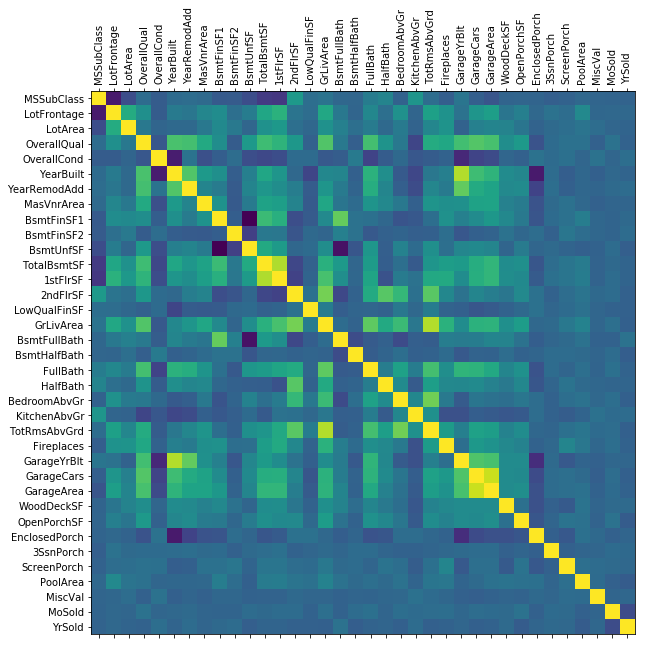

In [5]:
print(Xn.shape)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

Xnum = Xn.select_dtypes(include=numerics)
print(Xnum.shape)

def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical');
    plt.yticks(range(len(corr.columns)), corr.columns)

plot_corr(Xnum,size=10)    

Let's see an interesting comparison of the two variables that are correlated

C:\Users\17189\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


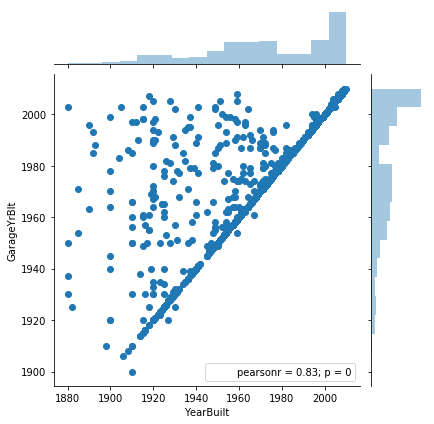

In [6]:
import seaborn as sns
import scipy.stats as stats #used to get correlation coefficient

#sns.set(style="darkgrid", color_codes=True)
j=sns.jointplot(x='YearBuilt', y='GarageYrBlt', data=Xnum)
j.annotate(stats.pearsonr)

### Screen step 4: Hot Coding with Imputation Method (then screen out for low variance)

We hot-code to get the dummies, and then recheck to remove dummy variables that satisfy 90% distribution criteria. After removing the columns, I will use the Imputation method 

In [195]:
#Fallback Cell
#Xj=Xn
Xn=Xj

In [7]:
from sklearn.preprocessing import Imputer

#IMPUTATION WITH MISSING COLUMNS

    #Find index of missing columns
cols_with_missing = (col for col in Xn.columns 
                                 if Xn[col].isnull().any())

    #For the respective index, add a New Column with the missing designation
for col in cols_with_missing:
    Xn[col + '_was_missing'] = Xn[col].isnull()

    # Find index low cardinality of text columns; which is defined by object
low_cardinality_cols = [cname for cname in Xn.columns if 
                                Xn[cname].nunique() < 10 and
                                Xn[cname].dtype == "object"]
    # Find index of numerical columns
numeric_cols = [cname for cname in Xn.columns if 
                                Xn[cname].dtype in ['int64', 'float64']]
my_cols = low_cardinality_cols + numeric_cols

# ONE HOT ENCODING
Xn = Xn[my_cols]
Xn = pd.get_dummies(Xn)
Xn = Xn.select_dtypes(exclude=['object'])

print('One Hot Dimensions are:' + str(Xn.shape))

# Remove weak dummies
for col in Xn.columns:
    if Xn[col].dtype == "uint8" and (Xn[col].value_counts()/1460)[0] > 0.90:
        Xn= Xn.drop([col], axis=1)
    
#IMPUTATION after removing object variables
my_imputer = Imputer()
Xi = my_imputer.fit_transform(Xn)
Xi = pd.DataFrame(Xi)
Xi.columns = Xn.columns

print('Final Dimensions are:' + str(Xi.shape))


One Hot Dimensions are:(1460, 152)
Final Dimensions are:(1460, 79)


C:\Users\17189\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### XGBoost <a name="xgboost"></a>

It's the leading model for tabular data and does not fare well with images and text

* XGBoost stands for eXtreme Gradient Boosting.
    * Boosting Model works by taking a collection or **ensemble** of weak learner models and then combining and weighing them to create a strong model. This process is called boosting
* XGBoost excels in execution speed and model performance
* Compared to other tree models
    * Requires more paramter tuning than Random Forest
    * It has low bias and high variance; making it susceptible to overfitting
    * The package has a special matrix that automatically (?) normalize numerical features and "hot code" categorical variables 
* [XGBoost: Use Case and Examples](https://github.com/dmlc/xgboost/tree/master/demo#code-examples)
* Can be used for regression; logistic regression (decision only), binary logistic (probability) 
    * Specified with objective option 
* Supports **Regularization**, which simply means putting penalties for complex models and reduce them
    * this is specified with gamma, alpha, lambda specification
* Supports three types of baselearner with **gbtree** as default, where other options include gblinear, and dart
* Supports **cross validation** robustness checks as well
* Compared to other machine learning algorithms it typically has poor insight on relationship of feature variables
    * The SHAP package does a decent job in illustrating relationships of the finalized model
* The Evaluation of the model is accuracy; for multi-classification it's a confusion matrix
    
**When to use boost:**
* large data; 1000 sample and less than 100 features
* Features< less number of training
* Tend to do well when combination of categorical and numerical; really well when just numerical
* For problems like rank and recommender systems
    
**When not to use boost:**
* Image Recognition
* Computer Vision
* Natural Language. Understanding problem (Deep learning used)



#### How does it work?

![title](Images\XGBoost.png)

We go through cycles that repeatedly builds new models and combines them into an ensemble model. We start the cycle by calculating the errors for each observation in the dataset. We then build a new model to predict those. We add predictions from this error-predicting model to the "ensemble of models."

To make a prediction, we add the predictions from all previous models. We can use these predictions to calculate new errors, build the next model, and add it to the ensemble.



[Quick Intro to Boosting](https://www.analyticsvidhya.com/blog/2015/11/quick-introduction-boosting-algorithms-machine-learning/)


#### Tree Parameters


![title](Images\Tree_Basics.png)


[Boosting Algoeithms Simplified](https://www.analyticsvidhya.com/blog/2015/05/boosting-algorithms-simplified/)



#### Initiate Standard Model XBG Regression Model <a name="setup"></a>

I use the screening data from earlier (Xi,yi). We use a special DMatrix which is specifically designed to be more efficient than the standard matrix for training and tweeking the model

In [9]:
from xgboost import XGBRegressor
import xgboost as xgb

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(Xi, yi, test_size=0.2, random_state=7)
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)


### Tuning of the variables <a name="tuning"></a>

XGBoost has a few parameters that can dramatically affect your model's accuracy and training speed. Unfortunately, parameter tuning is extremely to have complete precision as it based on multitude of dimensions. The bare basics are recommended by experts The order of tuning variables should be decided carefully. You should take the variables with a higher impact on outcome first. For instance, max_depth and min_samples_split have a significant impact and we’re tuning those first. I followed these two guides

[Guide 1](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)

[Guide 2](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)


**Overall Strategy**

1) Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems

2) Determine the optimum number of trees for this learning rate. This should range around 40-70. Remember to choose a value on which your system can work fairly fast. This is because it will be used for testing various scenarios and determining the tree parameters.

3) Tune tree-specific parameters for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.

4) Lower the learning rate and increase the estimators proportionally to get more robust models.


**Starting point?**

1) min_samples_split = : This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.

2) min_samples_leaf = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.

3) max_depth = 8 : Should be chosen (5-8) based on the number of observations and predictors. This has 87K rows and 49 columns so lets take 8 here.

4) max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.

5) subsample = 0.8 : This is a commonly used used start value

**FineTuning**

1) **n_estimators** specifies how many times to go through the modeling cycle; its typically between 100-1000 but depends on learning rate

2) The argument **early_stopping_rounds** offers a way to automatically find the ideal value. Model stops iterating when there is no improvement in validation score.
* Typically a good idea to set large n_estimator and early stopping round.
* Given some of the random nature, it is reasonable to set **early_stopping_rounds = 5**. The algorithm stops if the next five rounds have deterioration of validation score

3) This process is very computational; it is recommended to find the "n" using a subset of the sample and then putting the n for the training data. 

4) In general, a **small learning rate (and large number of estimators)** will yield more accurate XGBoost models, though it will also take he model longer to train since it does more iterations through the cycle

5) Tune max_depth and num_samples_split

6) Tune min_samples_leaf

7) Tune max_features

8) Subsample  which is for each tree the % of rows taken to build the tree. I recommend not taking out too many rows, as performance will drop a lot. Take values from 0.8 to 1

9) Learning Rate

10) colsample_bytree: number of columns used by each tree. In order to avoid some columns to take too much credit for the prediction. Values from 0.3 to 0.8 if you have many columns (especially if you did one-hot encoding), or 0.8 to 1 if you only have a few columns.

11) Gamma: usually misunderstood parameter, it acts as a regularization parameter. Either 0, 1 or 5.



### Model Tuning <a name="model"></a>

I tune the parameters manually; The meticulous process is using a gridsearch. It is a computational exhaustive process. So I did it manually

In [256]:
Xi.shape

(1460, 79)

In [15]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error


# Set Parameters first as default and then start changing in structured way
params = {
    "max features": 'sqrt',
    "max_depth": 5, #-1
    "subsample": 0.8,
    "min_samples_split": 14, # stay same
    "eta": 0.215,#215
    'min_samples_leaf':5, #stay same
    'random_state':0,
    'colsample_bytree':1, #stay default
    'gamma': 1, #doesnt matter
    'n_jobs': 4 #allow parallelization based on total number of cores
    
}

xg_reg = xgb.train(params, xgb_train, 250, evals = [(xgb_test, "test")], verbose_eval=5, early_stopping_rounds=100 )
#type(model_train)
# 5 test-rmse:32852.5 [30]	test-rmse:31160.6 [30]	test-rmse:29189 test-rmse:27530.1 ; 18; test-rmse:25633.8 (47),
# [32]	test-rmse:25430.5 
#best one
#[41]	test-rmse:25165



[0]	test-rmse:163342
Will train until test-rmse hasn't improved in 100 rounds.
[5]	test-rmse:59420.9
[10]	test-rmse:31978.1
[15]	test-rmse:26719.2
[20]	test-rmse:25977.7
[25]	test-rmse:25733.7
[30]	test-rmse:25427.3
[35]	test-rmse:25292.6
[40]	test-rmse:25177
[45]	test-rmse:25275.1
[50]	test-rmse:25307
[55]	test-rmse:25322.6
[60]	test-rmse:25285.6
[65]	test-rmse:25381
[70]	test-rmse:25482.1
[75]	test-rmse:25442.5
[80]	test-rmse:25468
[85]	test-rmse:25517.7
[90]	test-rmse:25493.5
[95]	test-rmse:25487.5
[100]	test-rmse:25456.4
[105]	test-rmse:25465.5
[110]	test-rmse:25474.8
[115]	test-rmse:25489.8
[120]	test-rmse:25458.8
[125]	test-rmse:25487.8
[130]	test-rmse:25447.1
[135]	test-rmse:25450.9
[140]	test-rmse:25440.4
Stopping. Best iteration:
[41]	test-rmse:25165



#### Run the model and evaluate

Notice we use Rquare, and the final model does not use the DMatrix

In [102]:
xg_reg  = xgb.XGBRegressor(n_estimators=41, learning_rate=0.215, gamma=0, subsample=0.8,colsample_bytree=1, max_depth=5, n_jobs=4)
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)

print('Train Rsquared: ' +  str(xg_reg.score(X_train,y_train)))
print('Test Rsquared: ' +  str(xg_reg.score(X_test, y_test)))

Train Rsquared: 0.9852599060777664
Test Rsquared: 0.9123535006263364


### Cross Validation Process <a name="cv"></a>

We change the tuned parameters a bit; to see if there is any differences after using cross-validation. The training accuracy is better, but the testing accuracy was less accurate.

In [18]:
from sklearn.model_selection import cross_val_score

#Model Specifications
xg_reg_cv  = xgb.XGBRegressor(n_estimators=41, learning_rate=0.214, gamma=0, subsample=0.80,colsample_bytree=1, max_depth=5, n_jobs=4)

#Find the Cross Validation Score
scores = -1 * cross_val_score(xg_reg_cv, Xi, yi,
                              cv=3, #number of folds
                              scoring='neg_mean_absolute_error')


#Print the mean of values
print("MAE scores:\n", scores.mean())


MAE scores:
 16748.503135613308


In [16]:
#Same Values

xg_reg_cv  = xgb.XGBRegressor(n_estimators=41, learning_rate=0.214, gamma=0, subsample=0.80,colsample_bytree=1, max_depth=5, n_jobs=4)
xg_reg_cv.fit(X_train,y_train)
y_pred_cv = xg_reg_cv.predict(X_test)

print('Train Rsquared: ' +  str(xg_reg_cv.score(X_train,y_train)))
print('Test Rsquared: ' +  str(xg_reg_cv.score(X_test, y_test)))

Train Rsquared: 0.9860974699081698
Test Rsquared: 0.9056946530769964


### Plotting Visuals <a name="plot"></a>

Note: You need to do the following to view the  graph; Remember to pip uninstall graphviz prior to setup

conda install -c conda-forge graphviz xorg-libxrender xorg-libxpm

pip install graphviz

#### Tree Plot
Note: Code only works for XGBooster class. I keep getting the same error. Not sure whats wrong with the map

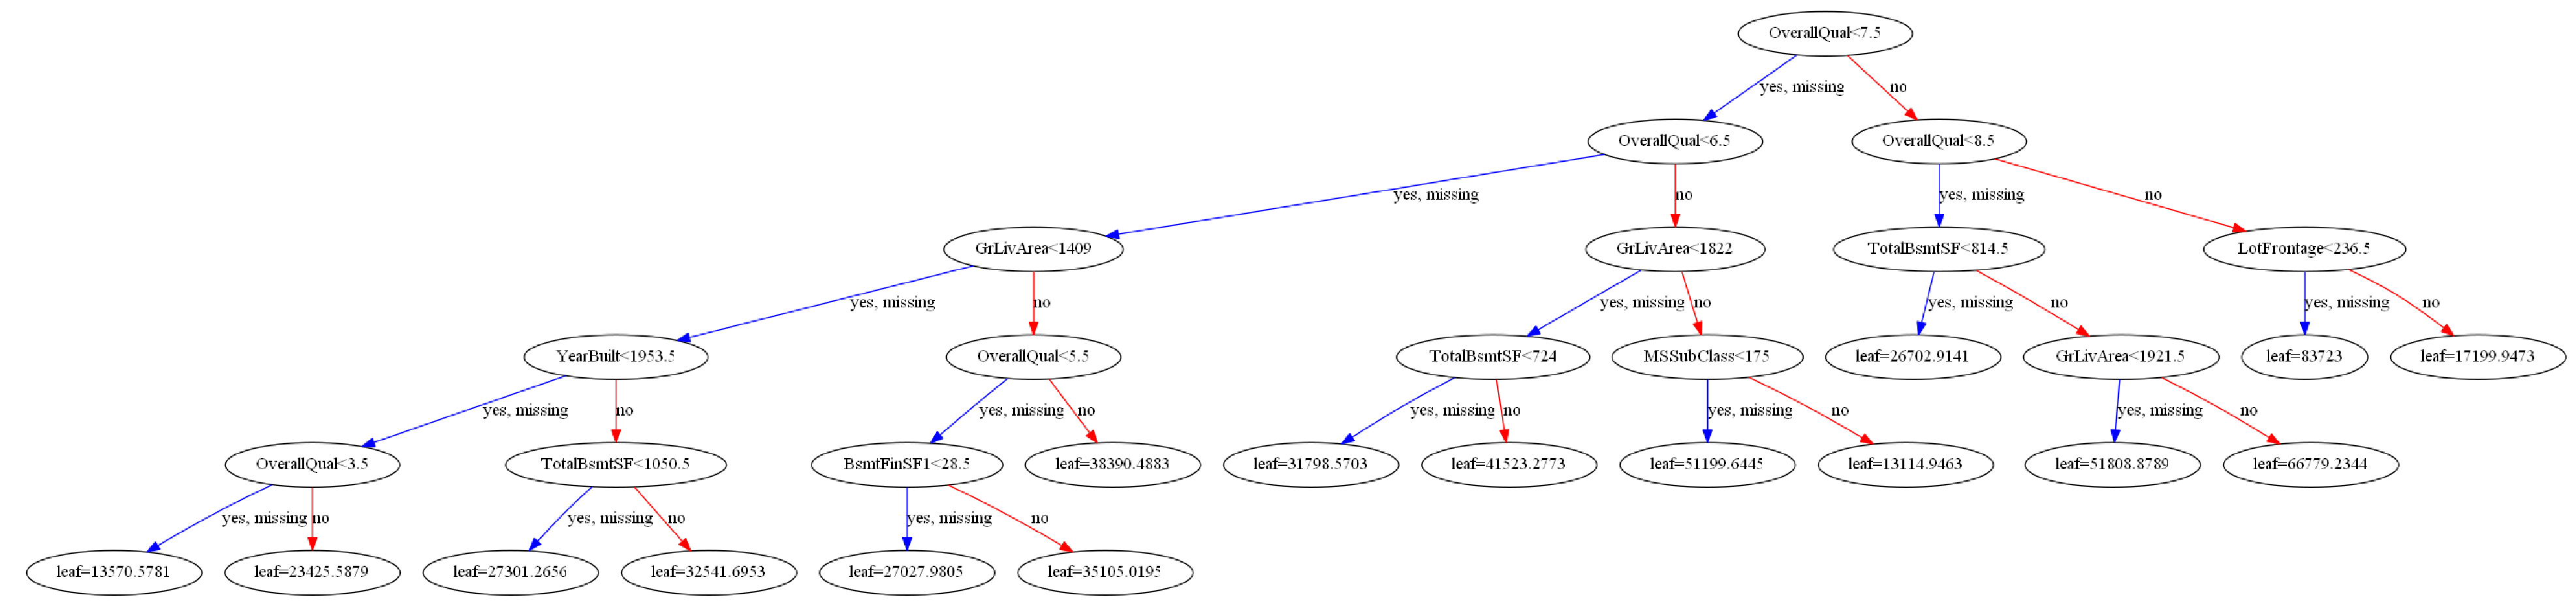

In [20]:
#xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

import matplotlib.pyplot as plt
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [70, 100]
plt.show()

### Feature Importance by Weight (Default)

Weight says how much time a feature appear in a tree.

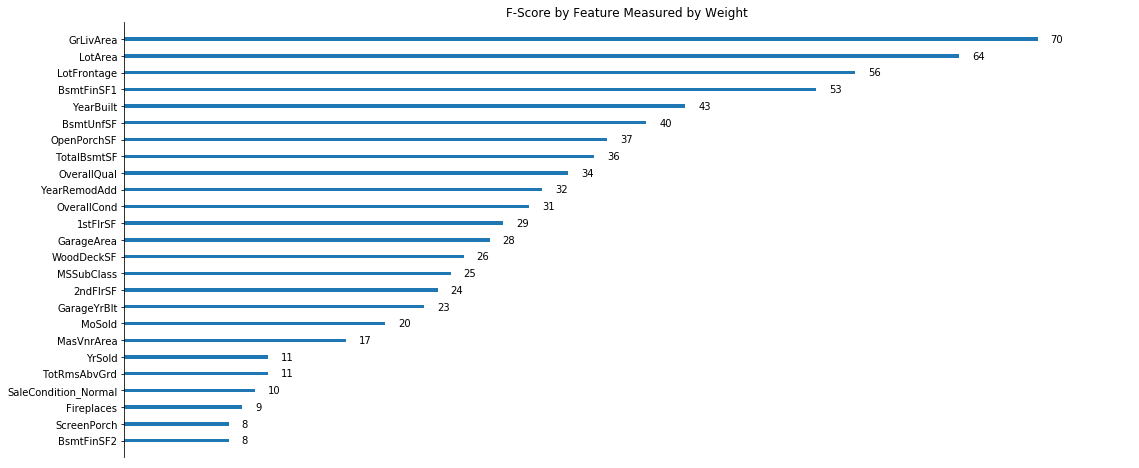

In [105]:
plt.rcParams["axes.spines.bottom"] = False
xgb.plot_importance(xg_reg, max_num_features =25, grid=False, xlabel=None, ylabel=None, title='F-Score by Feature Measured by Weight')
plt.rcParams['figure.figsize'] = [18, 8]
plt.xticks([])
#plt.xtitle('')
plt.show()

plt.rcParams["axes.spines.bottom"] = True


### Feature Importance by Gain

Gain is the average gain of splits which use the feature

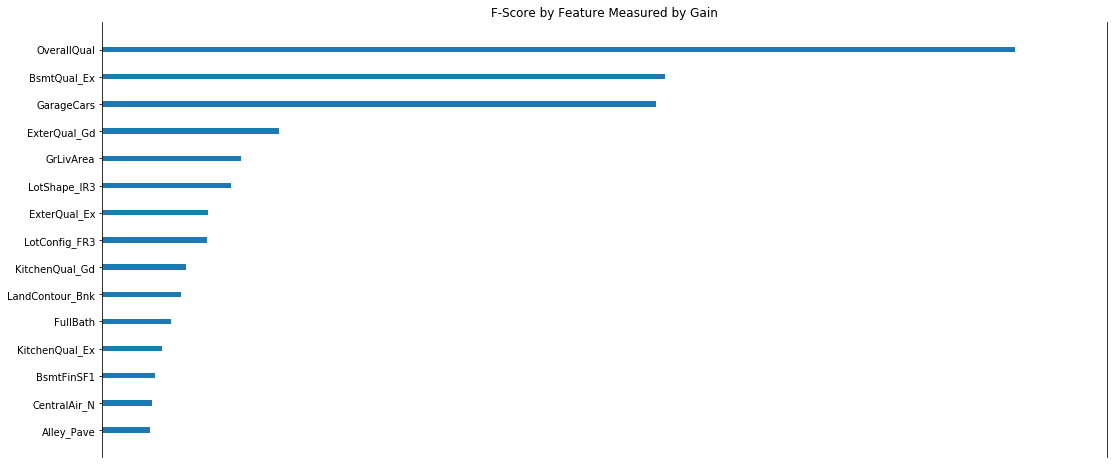

In [70]:
plt.rcParams["axes.spines.bottom"] = False
xgb.plot_importance(xg_reg, importance_type='gain', max_num_features =15, grid=False, xlabel=None, ylabel=None,
                    show_values=False, title='F-Score by Feature Measured by Gain')
plt.rcParams['figure.figsize'] = [18, 10]
plt.xticks([])
#plt.xtitle('')
plt.show()

plt.rcParams["axes.spines.bottom"] = True


### Feature Importance by Cover

Cover is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

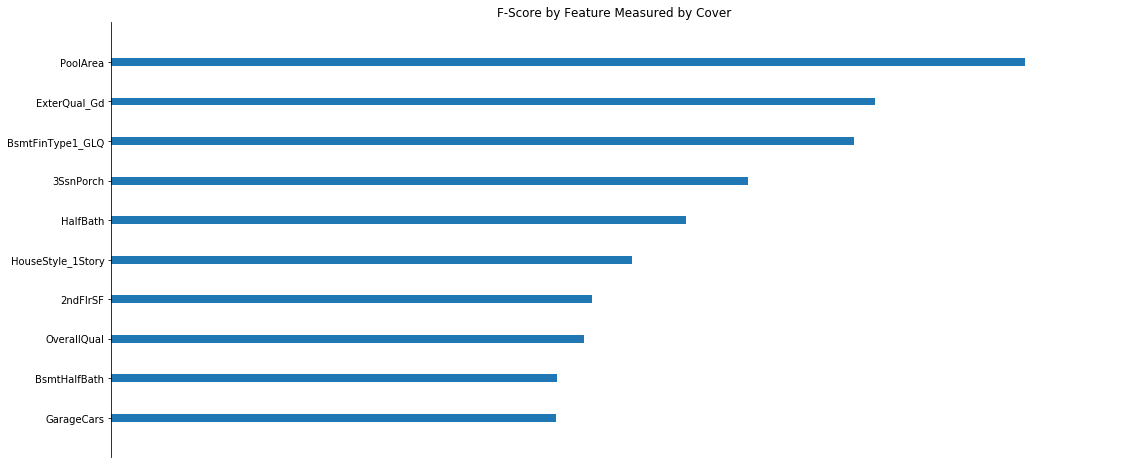

In [275]:
plt.rcParams["axes.spines.bottom"] = False
xgb.plot_importance(xg_reg, importance_type='cover', max_num_features =10, grid=False, xlabel=None, ylabel=None,
                    show_values=False, title='F-Score by Feature Measured by Cover')
plt.rcParams['figure.figsize'] = [18, 10]
plt.xticks([])
#plt.xtitle('')
plt.show()

plt.rcParams["axes.spines.bottom"] = True


#### Partial Dependence Plot

How does the feature impact price? blue bands are confidence interval

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1b280ba2320>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1b2f6faa080>})

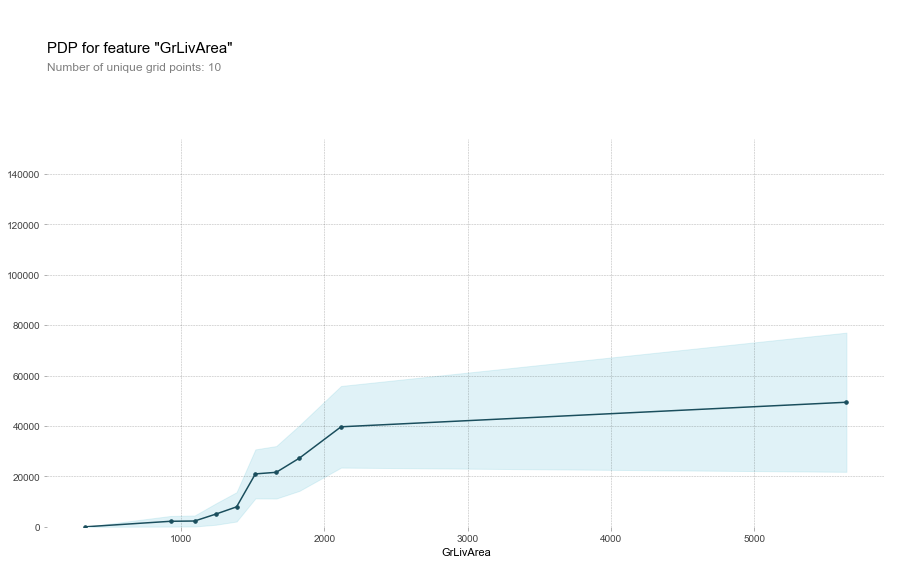

In [302]:
from pdpbox import pdp

#USe code below to get display of columns
#Xi.columns

df_X = pd.DataFrame(Xi, columns=[ 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR1',
       'LotShape_Reg', 'LandContour_Lvl', 'Condition1_Norm', 'BldgType_1Fam',
       'HouseStyle_1.5Fin', 'HouseStyle_1Story', 'HouseStyle_2Story',
       'RoofStyle_Gable', 'RoofStyle_Hip', 'MasVnrType_BrkFace',
       'MasVnrType_None', 'ExterQual_Gd', 'ExterQual_TA', 'ExterCond_Gd',
       'ExterCond_TA', 'Foundation_BrkTil', 'Foundation_CBlock',
       'Foundation_PConc', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtCond_TA',
       'BsmtExposure_Av', 'BsmtExposure_No', 'BsmtFinType1_ALQ',
       'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_Unf',
       'HeatingQC_Ex', 'HeatingQC_Gd', 'HeatingQC_TA', 'KitchenQual_Gd',
       'KitchenQual_TA', 'GarageType_Attchd', 'GarageType_Detchd',
       'GarageFinish_Fin', 'GarageFinish_RFn', 'GarageFinish_Unf',
       'GarageQual_TA', 'SaleType_WD', 'SaleCondition_Normal'])

feature = 'GrLivArea'
p = pdp.pdp_isolate(xg_reg, df_X, df_X.columns, feature)
pdp.pdp_plot(p, feature)

## SHAP package: Feature Dependency and plotting <a name="Shap"></a>

The XGBoost model features does not do an effective job in explaining how much a feature has on target, what is the magnitude, and what is the variance.

The tree SHAP model considers both consistency and accuracy,and its better than other weighted models such as the standard 'Gain'. Read [article](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27)  

Tree SHAP method is mathematically equivalent to averaging differences in predictions over all possible orderings of the features, rather than just the ordering specified by their position in the tree.

**SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value**

[LINK! The mathematical theory and Game Theory roots of Shapley values](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d)
    * Imagine having three players whom talent bring some value, but overlaps with other players, what is the value of each player, and does each player value or contribution based on the order they join the team. This dilemma is what fueled the formulation of Shapley Values, which can be understood at a high level as “finding each player’s marginal contribution, averaged over every possible sequence in which the players could have been added to the group”. So, in the case outlined above, you would simulate the arrival sequences: ABC, ACB, BCA, BAC, CAB, and CBA, and for each sequence, capture the marginal payoff that accrued to each player. Then, average all of these payoffs together, and you have the Shapley values for each player.


### Setup

In [21]:
import shap
#enables javascipt in notebook
shap.initjs()


#Intitiate SHAP class to previous model used
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(Xi)


#An Interaction value parameter across all dimensions; this can be time consuming
shap_interaction_values = shap.TreeExplainer(xg_reg).shap_interaction_values(Xi.iloc[:2000,:])


### SHAP Plot

**Interpretation**: the output value is the predicted value and the base value is the actual value. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from OverallQual=7. Though the ball possession value has a meaningful effect decreasing the prediction.

In [22]:
# this is for the first row value
shap.force_plot(explainer.expected_value, shap_values[0,:], Xi.iloc[0,:])

In [44]:
# this is for the second row entry
shap.force_plot(explainer.expected_value, shap_values[1,:], Xi.iloc[1,:])

#### Create a function that can show predictive impacts for individual entry

To do this on predictive scale you would need a column with unique values sequentially to serve as key to specific individual

In [24]:
def housing_factors(model, data, num):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data.iloc[num])
    shap.initjs
    return shap.force_plot(explainer.expected_value, shap_values[0,:], data.iloc[num])

#I've selected the 57th entry
housing_factors(xg_reg, Xi, 51)


### Feature Importance Plot

Notice that is **different** from the normal XGBoost importance metric!; For the second graph, the vertical line is designated at the mean

When plotting, we call shap_values[1]. For classification problems, there is a separate array of SHAP values for each possible outcome. In this case, we index in to get the SHAP values for the prediction of "True". **Note:** SHAP varies for every model!

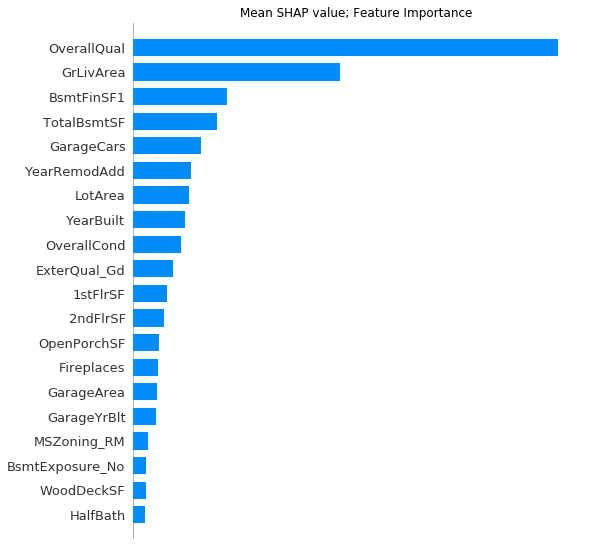

In [306]:
plt.rcParams["axes.spines.bottom"] = False

shap.summary_plot(shap_values, Xi, plot_type="bar", show=False)

#Change axises and chart
plt.xticks([])
plt.title('Mean SHAP value; Feature Importance')
plt.xlabel("")
plt.rcParams["axes.spines.bottom"] = True

Text(0.5, 1.0, 'SHAP Value (Feature Impact on Price)')

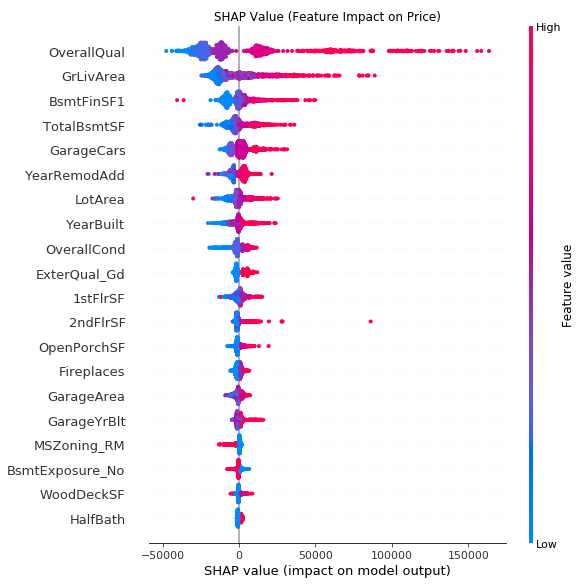

In [117]:
#Remove Bottom spine and then activate it again after plot is made
#plt.rcParams["axes.spines.bottom"] = False

#Intitiate SHAP class to previous model used
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(Xi)



#Plot
shap.summary_plot(shap_values, Xi,show=False)

#Change axises and chart
#plt.xticks([])
plt.title('SHAP Value (Feature Impact on Price)')
#plt.xlabel("")
#plt.rcParams["axes.spines.bottom"] = True

This plot is made of many dots. Each dot has three characteristics:

* Vertical location shows what feature it is depicting
* Color shows whether that feature was high or low for that row of the dataset
* Horizontal location shows whether the effect of that value caused a higher or lower prediction.
* the clumps are kind of density and points can be mixed together.

For example, for some houses, the overall quality predicted the price of the house fairly, as it can be show by the magnitude of price. 

### SHAP Interaction Value Summary Plot

For some reason, I cant remove the x axis values. The interaction plot by default compares the 7 weighted features.

([], <a list of 0 Text xticklabel objects>)

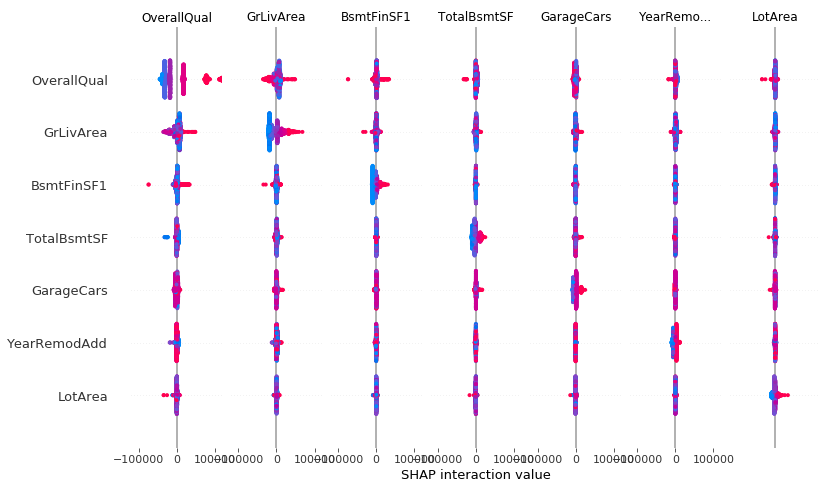

In [316]:
plt.rcParams["axes.spines.bottom"] = False

#interaction Plot
shap.summary_plot(shap_interaction_values, Xi.iloc[:2000,:], show=False)

plt.xlabel("")
plt.xticks([])
#plt.rcParams["axes.spines.bottom"] = True

### SHAP Partial Dependence Plot of the top 5 variables <a name="dependence"></a>

what is the distribution of effects? Is the effect of having a certain value pretty constant, or does it vary a lot depending on the values of other feaures. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail

Start by focusing on the shape. Each dot represents a row of the data. The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction. The fact this slopes upward says that the more you possess the ball, the higher the model's prediction is for winning the Man of the Match award.




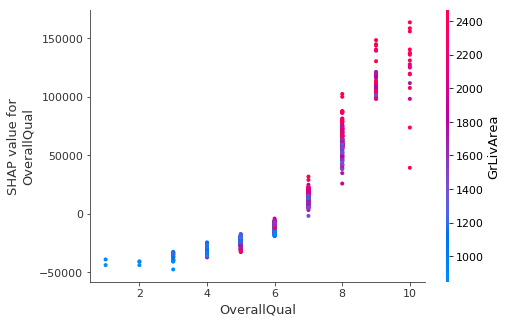

In [108]:
#plt.rcParams["axes.spines.right"] = True
#plt.rcParams["axes.spines.left"] = False

# the dependence plot automatically picked the variable most connected with it 
shap.dependence_plot("OverallQual", shap_values, Xi,show=False)
#plt.ylabel("")
#plt.yticks([])
#plt.title('Partial Dependence OverallQual and GrLivArea')

#plt.rcParams["axes.spines.right"] = False
#plt.rcParams["axes.spines.left"] = True

#### Interpretation: How do we interpret the graph above?

* First we see the data is constructed in bands, this is because OverallQual is an integer variable, and there is greater predictability when overallQual is greater than 7, this aligns to the tree graph, where the first split occured!
* Second, OverallQual is typically a poor predictor when less than 6. This indicates that other features are explaining the price for those points.
* Third, there is a somewhat strong correlation with GrLivArea, where overall quality tend to have larger space (**that is the color part**)

(0, 5000)

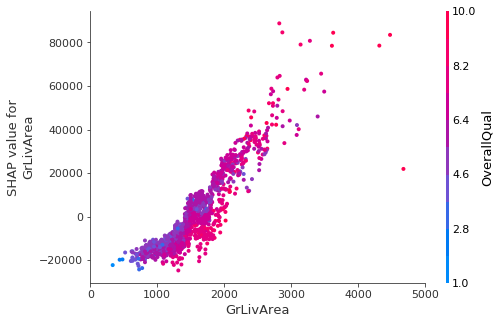

In [109]:
#plt.rcParams["axes.spines.right"] = True
#plt.rcParams["axes.spines.left"] = False

# the dependence plot automatically picked the variable most connected with it 
shap.dependence_plot("GrLivArea", shap_values, Xi,show=False)
#plt.ylabel("")
#plt.yticks([])
#plt.title('Partial Dependence GrLivArea and OverallQual')
plt.xlim(0,5000)

#plt.rcParams["axes.spines.right"] = False
#plt.rcParams["axes.spines.left"] = True

(0, 3400)

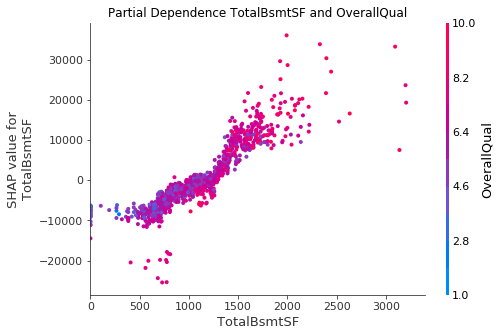

In [110]:
#plt.rcParams["axes.spines.right"] = True
#plt.rcParams["axes.spines.left"] = False

# the dependence plot automatically picked the variable most connected with it 
shap.dependence_plot("TotalBsmtSF", shap_values, Xi,show=False)
#plt.ylabel("")
#plt.yticks([])
plt.title('Partial Dependence TotalBsmtSF and OverallQual')
plt.xlim(0,3400)

#plt.rcParams["axes.spines.right"] = False
#plt.rcParams["axes.spines.left"] = True

(0, 2500)

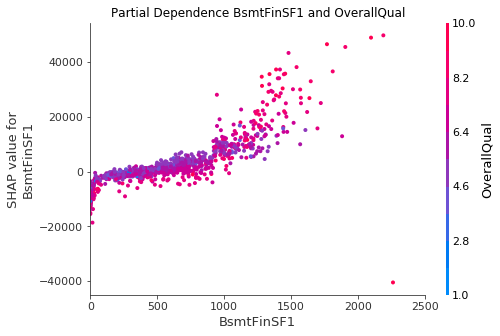

In [111]:
#plt.rcParams["axes.spines.right"] = True
#plt.rcParams["axes.spines.left"] = False

# the dependence plot automatically picked the variable most connected with it 
shap.dependence_plot("BsmtFinSF1", shap_values,Xi,show=False)
#plt.ylabel("")
#plt.yticks([])
plt.title('Partial Dependence BsmtFinSF1 and OverallQual')
plt.xlim(0,2500)

#plt.rcParams["axes.spines.right"] = False
#plt.rcParams["axes.spines.left"] = True

Text(0.5, 1.0, 'Partial Dependence YearBuilt and GrlivArea')

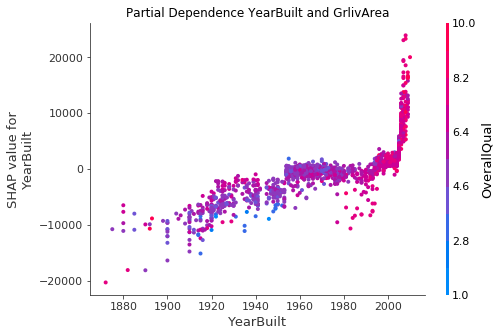

In [112]:
#plt.rcParams["axes.spines.right"] = True
#plt.rcParams["axes.spines.left"] = False

# the dependence plot automatically picked the variable most connected with it 
shap.dependence_plot("YearBuilt", shap_values, Xi,show=False)
#plt.ylabel("")
#plt.yticks([])
plt.title('Partial Dependence YearBuilt and GrlivArea')

#plt.rcParams["axes.spines.right"] = False
#plt.rcParams["axes.spines.left"] = True

### SHAP Interaction Value Dependence Plots

By mapping the interaction, we can see where the information of data varies. For example, the graph below shows the relationship between GrLivArea and OverallQual respect to price. For example, the graph below shows that quality homes of 5 but large GrLivArea actually cost quite less (maybe this is an abandoned large property). When quality is improving, the size of GrLivArea is more important in determining the price. There seems to be positive correlation between high quality houses and GrLivArea. Note: this is based on 2000 points on the data. We can explore other relationships, but end it here

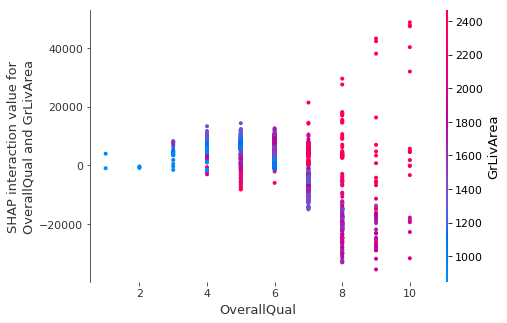

In [324]:
shap.dependence_plot(
    ("OverallQual", "GrLivArea"),
    shap_interaction_values, Xi.iloc[:2000,:],
    display_features=Xi.iloc[:2000,:], show=False
)

### Interaction Value Matrix <a name="matrix"></a>

The code is a bit hard to follow, but it provides an Interaction Value Matrix. We can see quick relationship of certain values. For example, there is an interesting relationship between FullBath and OverallQual. Even though FullBath has little explanatory value in determining the overall price, it is able to help explain variation on Overall Quality. This can be seen with FullBath being the most meaningful feature on the standard XGBoost when the feature_importance was designated to "Gain"

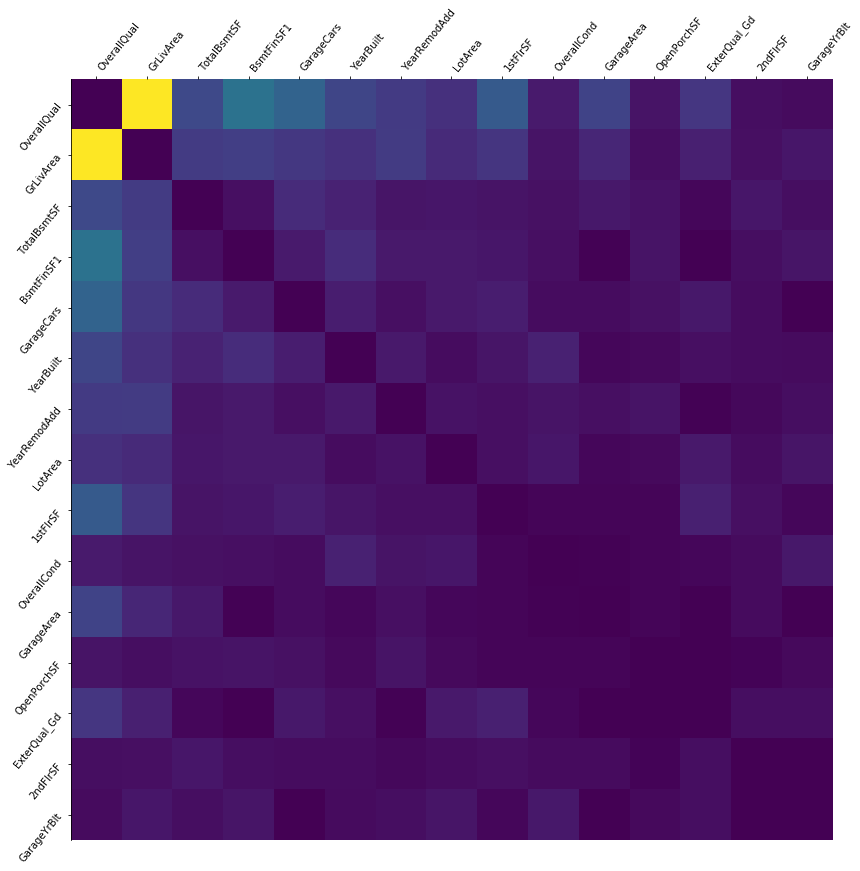

In [328]:
import matplotlib.pylab as pl
import numpy as np

#Not sure  what this do
tmp = np.abs(shap_interaction_values).sum(0)
#Creates a zero diagnol matrix for each dimension
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
#We select the index and the number of columns of interest (20) based on a sorting sum of weight    
inds = np.argsort(-tmp.sum(0))[:15]
#We update the previous matrix; while protecting the diagnol values
tmp2 = tmp[inds,:][:,inds]

#Graphical Features
pl.figure(figsize=(14,14))
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), Xi.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), Xi.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.show()

### Resources

1) [SHAPExample with Survival Model](https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html)

2) [League of Legend Win Condition (XGBoost:Logistic Classification)](https://slundberg.github.io/shap/notebooks/League%20of%20Legends%20Win%20Prediction%20with%20XGBoost.html)

3) [Github: SHAP](https://github.com/slundberg/shap)

4) [Article Explaining SHAP and why important](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27)

NameError: name 'model' is not defined

**Partial Dependence Plots** <a name="partial"></a>

It helps answer questions about how much impact something has on a model controlling fro certain features; similar to regression coefficients in a linear model. **The partial dependence plot is calculated only after the model has been fit.**

![title](Documents\GitHub\wine-reviews\PartialDepPlots.png)

The example below shows the survival rate during the sinking of the Titanic. Notice, the kids survive first, and wealthy people have greater change of surviving.

In [92]:

X.head()

,Distance,Landsize,BuildingArea
0,2.5,202.0,NaN
1,2.5,156.0,79.0
2,2.5,134.0,150.0
3,2.5,94.0,NaN
4,2.5,120.0,142.0


xgboost.sklearn.XGBRegressor

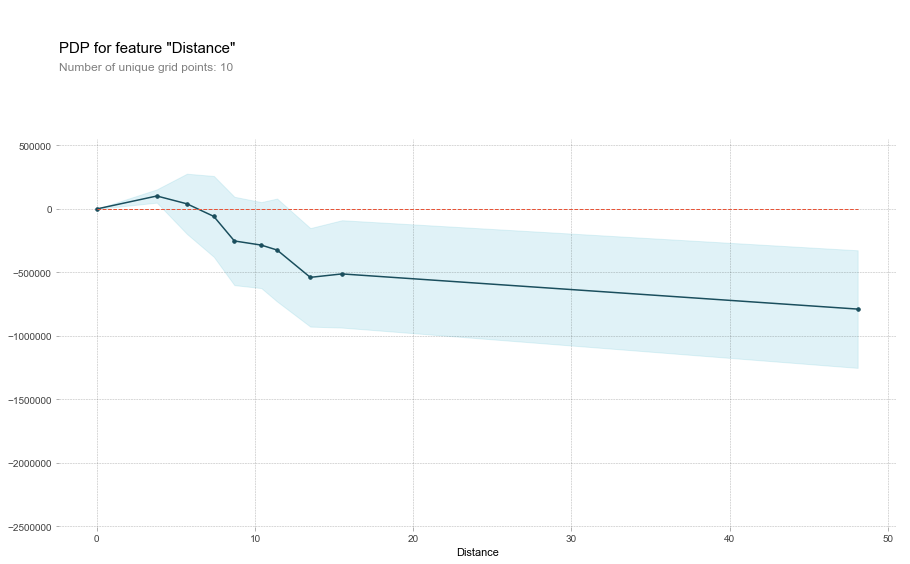

In [103]:
from xgboost import XGBRegressor
from pdpbox import pdp

def get_some_data():
    cols_to_use = ['Distance', 'Landsize', 'BuildingArea','Method']
    data = pd.read_csv("Documents\GitHub\wine-reviews\melb_data.csv")
    y = data.Price
    X = data[cols_to_use]
    X = pd.get_dummies(X)
    #my_imputer = Imputer()
    #imputed_X = my_imputer.fit_transform(X)
    return X, y

X, y = get_some_data()
#print(X)
# convert to DataFrame as pdp package requires a DataFrame
X = pd.DataFrame(X, columns=['Distance', 'Landsize', 'BuildingArea'])
my_model = XGBRegressor()
my_model.fit(X, y)
feature = 'Distance'
p = pdp.pdp_isolate(my_model, X, X.columns, feature)
pdp.pdp_plot(p, feature)
type(my_model)

In [45]:
otto_data.head(2)

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,target,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8
0,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


### Data Leakage <a name="leakage"></a>

**Data leakage** (or leakage) happens when your training data contains information about the target, but similar data will not be available when the model is used for prediction. This leads to high performance on the training set (and possibly even the validation data), but the model will perform poorly in production.

There are two main types of leakage: **target leakage and train-test contamination.**

#### Target Leakage
**Target leakage** occurs when your predictors include data that will not be available at the time you make predictions. It is important to think about target leakage in terms of the timing or chronological order that data becomes available, not merely whether a feature helps make good predictions.

Imagine you want to predict who will get sick with pneumonia. Suppose there is a column called "took anti-biotics" and it was used in the model for prediction. This datapoint is determined after someone is sick; this information provides no value in providing prediction, so it should be excluded.

![title](Documents\GitHub\wine-reviews\Pred.png)

#### Train-Test Contamination

Recall that validation is meant to be a measure of how the model does on data that it hasn't considered before. You can corrupt this process in subtle ways if the validation data affects the preprocessing behavior. This is sometimes called train-test contamination.

After all, you incorporated data from the validation or test data into how you make predictions, so the may do well on that particular data even if it can't generalize to new data. This problem becomes even more subtle (and more dangerous) when you do more complex feature engineering.

[Great Explanation/Example here](https://www.kaggle.com/alexisbcook/data-leakage)

In [423]:
import pandas as pd

# Read the data
data = pd.read_csv('Documents\GitHub\wine-reviews\AER_credit_card_data.csv', 
                   true_values = ['yes'], false_values = ['no'])

# Select target
y = data.card

# Select predictors
X = data.drop(['card'], axis=1)

print("Number of rows in the dataset:", X.shape[0])
X.head()

Number of rows in the dataset: 1319


,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,0,37.66667,4.5200,0.033270,124.983300,True,False,3,54,1,12
1,0,33.25000,2.4200,0.005217,9.854167,False,False,3,34,1,13
2,0,33.66667,4.5000,0.004156,15.000000,True,False,4,58,1,5
3,0,30.50000,2.5400,0.065214,137.869200,False,False,0,25,1,7
4,0,32.16667,9.7867,0.067051,546.503300,True,False,2,64,1,5


In [424]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Since there is no preprocessing, we don't need a pipeline (used anyway as best practice!)
my_pipeline = make_pipeline(RandomForestClassifier(n_estimators=100))
cv_scores = cross_val_score(my_pipeline, X, y, 
                            cv=5,
                            scoring='accuracy')

print("Cross-validation accuracy: %f" % cv_scores.mean())

Cross-validation accuracy: 0.981043


The accuracy seems great; however some of the columns of having a card can directly impact other columns on the feature set. When we exclude these columns the model becomes less accurate but has more realistic predictability as oppose to normal method

In [425]:
expenditures_cardholders = X.expenditure[y]
expenditures_noncardholders = X.expenditure[~y]

print('Fraction of those who did not receive a card and had no expenditures: %.2f' \
      %((expenditures_noncardholders == 0).mean()))
print('Fraction of those who received a card and had no expenditures: %.2f' \
      %(( expenditures_cardholders == 0).mean()))

Fraction of those who did not receive a card and had no expenditures: 1.00
Fraction of those who received a card and had no expenditures: 0.02


In [426]:
# Drop leaky predictors from dataset
potential_leaks = ['expenditure', 'share', 'active', 'majorcards']
X2 = X.drop(potential_leaks, axis=1)

# Evaluate the model with leaky predictors removed
cv_scores = cross_val_score(my_pipeline, X2, y, 
                            cv=5,
                            scoring='accuracy')

print("Cross-val accuracy: %f" % cv_scores.mean())

Cross-val accuracy: 0.833963
